# Titanic Machine Learning from Disaster

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
test = pd.read_csv('data/test.csv',index_col='PassengerId')
train = pd.read_csv('data/train.csv',index_col='PassengerId')

Let's have a quick look at the data

In [3]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleaning

In [5]:
from sklearn.preprocessing import LabelEncoder  
le = LabelEncoder()

def clean_df(df):
    # Dropping the axis we'll not use
    df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    
    # Filling NAs
    df = df.fillna(df.mean())
    
    # Setting columns categories
    df['Sex'] = le.fit_transform(df['Sex'])

    # Normalizing
    df=((df-df.min())/(df.max()-df.min()))
    
    return df

Cleaning the training and testing sets

In [6]:
train = clean_df(train)
test = clean_df(test)

## Creating the classifier

Splitting the data

In [7]:
X_train = train.drop('Survived', axis=1)[['Fare', 'Sex', 'Pclass']]
y_train = train['Survived']
X_test = test[['Fare', 'Sex', 'Pclass']]

#### PCA

In [8]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Checking axis information

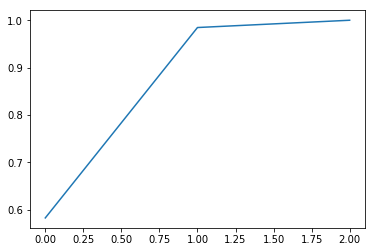

In [9]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.show()

Transforming axis

In [10]:
X_train_pca = pd.DataFrame(pca.transform(X_train))[[0,1]]
X_train_pca.index = X_train.index
X_test_pca = pd.DataFrame(pca.transform(X_test))[[0,1]]
X_test_pca.index = X_test.index

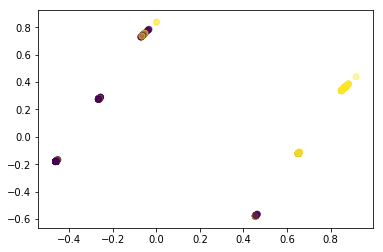

In [11]:
plt.scatter(X_train_pca.iloc[:,0], X_train_pca.iloc[:,1], c=y_train, alpha=0.4)
plt.show()

#### K-Means

In [12]:
kmeans = KMeans(n_clusters=6).fit(X_train_pca)

Labelling train and test pca

In [13]:
X_train_pca['label'] = kmeans.labels_
X_test_pca['label'] = kmeans.predict(X_test_pca)

#### LogisticRegression by cluster

In [14]:
gen_mean = 0
cluster_list = []

for i in range(6):
    
    cluster_train = X_train_pca[X_train_pca['label'] == i]
    cluster_test = X_test_pca[X_test_pca['label'] == i]
    idx = cluster_test.index
    
    clf = LogisticRegression()
    
    scores = cross_val_score(clf, cluster_train, y_train[cluster_train.index], cv=3)
    gen_mean += scores.mean()
    print(f"Cluster {i} has had a mean score of : {scores.mean()}")
    
    clf.fit(cluster_train, y_train[cluster_train.index])
    
    cluster_test.insert(loc=0, column = 'Survived', value = clf.predict(cluster_test).astype('int')) 
    cluster_list.append(cluster_test)     

print(gen_mean/6)

Cluster 0 has had a mean score of : 0.864567716141929
Cluster 1 has had a mean score of : 0.9210256410256411
Cluster 2 has had a mean score of : 0.6310975609756098
Cluster 3 has had a mean score of : 0.625
Cluster 4 has had a mean score of : 0.8427713427713428
Cluster 5 has had a mean score of : 0.9680779569892474
0.8087567029839616


Concatenating the cluster_tests from cluster_list

In [15]:
df_res = pd.DataFrame()
for elt in cluster_list:
    if df_res.empty:
        df_res = elt
    else:
        df_res = pd.concat([df_res, elt])

In [16]:
df_res = df_res[['Survived']]

In [17]:
df_res.to_csv('submission.csv')